In [108]:
import config as c
import utils as u
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
pdf = pd.read_parquet("poke_df.parquet")

In [110]:
pdf.drop(columns="cpoke_tit_timeout_adj").info()

KeyError: "['cpoke_tit_timeout_adj'] not found in axis"

In [6]:
tdf = u.load_trials_df()

Loading days data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication


In [ ]:
tdf.avg_settling_in.describe()

count    14728.000000
mean         0.280407
std          0.334200
min          0.000000
25%          0.057100
50%          0.136800
75%          0.384700
max          2.177500
Name: avg_settling_in, dtype: float64

In [15]:
tdf[['trial', 'animal_id', 'date', 'sess_id', 'violations','fix_experiment', 'stage', 'fixation_dur','inter_trial_dur', 'settling_in_determines_fixation', 'timeouts', 'n_settling_ins', 'avg_settling_in']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199845 entries, 0 to 199844
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype          
---  ------                           --------------   -----          
 0   trial                            199845 non-null  uint64[pyarrow]
 1   animal_id                        199845 non-null  string         
 2   date                             199845 non-null  object         
 3   sess_id                          199845 non-null  uint64[pyarrow]
 4   violations                       193269 non-null  uint64[pyarrow]
 5   fix_experiment                   199845 non-null  object         
 6   stage                            199845 non-null  float64        
 7   fixation_dur                     199845 non-null  float64        
 8   inter_trial_dur                  199845 non-null  float64        
 9   settling_in_determines_fixation  199845 non-null  float64        
 10  timeouts                        

In [44]:
import pandas as pd
import numpy as np

# ----------------------------
# 1.  Slice to the animal / session you want to test
# ----------------------------
animal = "R041"

pdf_sub = (
    pdf
    .query("animal_id == @animal")
    .copy()
)

tdf_sub = (
    tdf
    .query("animal_id == @animal")
    .copy()
)

# If you want to isolate a *single* session, pick one sessid first:
#   one_sess = pdf_sub['sessid'].iloc[0]
#   pdf_sub = pdf_sub.query("sessid == @one_sess")
#   tdf_sub = tdf_sub.query("sess_id == @one_sess")

# ----------------------------
# 2.  On the trials table – create prev_sma_iti
# ----------------------------
tdf_sub = (
    tdf
    .sort_values(["animal_id", "sess_id", "trial"])
)

tdf_sub["prev_sma_iti"] = (
    tdf_sub
    .groupby(["animal_id", "sess_id"])["inter_trial_dur"]
    .shift(1)
)

# – keep only what we need for the merge
tdf_keep = tdf_sub[["animal_id", "sess_id", "trial", "prev_sma_iti"]]

# ----------------------------
# 3.  On the cpoke table – flag *first* cpoke of each trial
# ----------------------------
pdf_sub = (
    pdf
    .sort_values(["animal_id", "sessid", "trial"])
)

pdf_sub["is_first_cpoke"] = (
    pdf_sub
    .groupby(["animal_id", "sessid", "trial"])
    .cumcount()
    == 0
)

In [45]:

# ----------------------------
# 4.  Merge prev_sma_iti onto the cpoke rows
# ----------------------------
merged = pdf_sub.merge(
    tdf_keep,
    left_on = ["animal_id", "sessid", "trial"],
    right_on = ["animal_id", "sess_id", "trial"],
    how = "left"
)

# drop the duplicate key that came from tdf
merged = merged.drop(columns="sess_id")


In [40]:
merged[["trial", "cpoke_dur", "cpoke_iti", "is_first_cpoke","prev_sma_iti"]].iloc[2000:2020]

,trial,cpoke_dur,cpoke_iti,is_first_cpoke,prev_sma_iti
2000,89,1.1964,13.734300,True,6.357131
2001,90,0.1389,32.119700,True,5.052587
2002,90,1.1594,0.315800,False,5.052587
2003,91,1.1689,16.817899,True,4.945708
2004,92,1.1787,28.115799,True,4.794968
2005,93,1.2299,34.514300,True,4.995874
2006,94,0.2765,15.908401,True,5.079100
2007,94,1.1853,0.084200,False,5.079100
2008,95,1.2958,21.679200,True,5.854991
2009,96,0.2747,18.392500,True,4.416913


In [46]:

# ----------------------------
# 5.  Keep prev_sma_iti *only* for the first cpoke of the trial
# ----------------------------
merged.loc[~merged["is_first_cpoke"], "prev_sma_iti"] = 0

# ----------------------------
# 6.  Compute the adjusted ITI
# ----------------------------
merged["cpoke_iti_adjusted"] = merged["cpoke_iti"] - merged["prev_sma_iti"]

In [ ]:

# defensive post-processing: if subtraction went negative, treat as missing
neg = merged["cpoke_iti_adjusted"] < 0
merged.loc[neg, ["prev_sma_iti", "cpoke_iti_adjusted"]] = np.nan

# ----------------------------
# 7.  Done – inspect results
# ----------------------------
merged[["animal_id","sessid","trial",
        "cpoke_iti","prev_sma_iti","cpoke_iti_adjusted",
        "is_first_cpoke"]]

,animal_id,sessid,trial,cpoke_iti,prev_sma_iti,cpoke_iti_adjusted,is_first_cpoke
0,R040,965069,2,72.409421,12.332821,60.076600,True
1,R040,965069,3,28.839480,5.777362,23.062118,True
2,R040,965069,4,12.954300,4.993989,7.960311,True
3,R040,965069,5,15.057600,4.821803,10.235797,True
4,R040,965069,6,13.752699,5.129691,8.623008,True
...,...,...,...,...,...,...,...
179946,R057,966978,337,10.168700,2.631407,7.537293,True
179947,R057,966978,338,0.097300,NaN,NaN,True
179948,R057,966978,339,15.058700,3.021916,12.036784,True
179949,R057,966978,340,27.879500,4.632623,23.246877,True


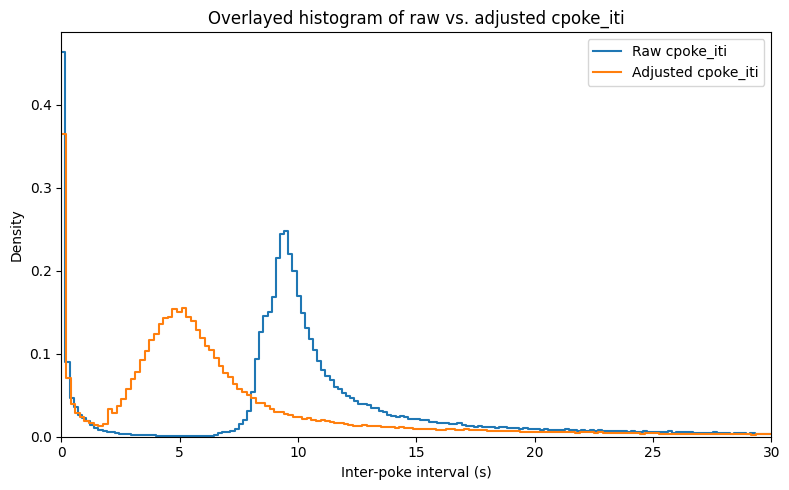

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

# Raw cpoke_iti
sns.histplot(
    data=merged,
    x="cpoke_iti",
    element="step",
    stat="density",
    label="Raw cpoke_iti",
    fill=False
)

# Adjusted cpoke_iti
sns.histplot(
    data=merged,
    x="cpoke_iti_adjusted",
    element="step",
    stat="density",
    label="Adjusted cpoke_iti",
    fill=False
)

plt.xlabel("Inter‐poke interval (s)")
plt.ylabel("Density")
plt.title("Overlayed histogram of raw vs. adjusted cpoke_iti")
plt.xlim(0, 30)
plt.legend()
plt.tight_layout()
plt.show()

In [59]:
tdf.query("stage in @c.GROWING_STAGES").groupby(["fix_experiment", "result"]).agg(
    avg_timeout_dur=("timeouts", "mean"),
    min_timeout_dur=("timeouts", "min"),
    max_timeout_dur=("timeouts", "max"),
    n_timeouts=("timeouts", "count")
).reset_index()

,fix_experiment,result,avg_timeout_dur,min_timeout_dur,max_timeout_dur,n_timeouts
0,V1,1,NaN,NaN,NaN,0
1,V1,2,0.1,0.1,0.1,2275
2,V1,3,2.0,2.0,2.0,17206
3,V1,6,NaN,NaN,NaN,0
4,V2,1,NaN,NaN,NaN,0
5,V2,2,0.1,0.1,0.1,1288
6,V2,3,0.1,0.1,0.1,4
7,V2,6,NaN,NaN,NaN,0


In [60]:
tdf.query("stage in @c.PROBE_STAGES").groupby(["fix_experiment", "result"]).agg(
    avg_timeout_dur=("timeouts", "mean"),
    min_timeout_dur=("timeouts", "min"),
    max_timeout_dur=("timeouts", "max"),
    n_timeouts=("timeouts", "count")
).reset_index()

,fix_experiment,result,avg_timeout_dur,min_timeout_dur,max_timeout_dur,n_timeouts
0,V1,1,NaN,NaN,NaN,0
1,V1,2,0.1,0.1,0.1,469
2,V1,3,2.0,2.0,2.0,3185
3,V1,6,NaN,NaN,NaN,0
4,V2,1,NaN,NaN,NaN,0
5,V2,2,0.1,0.1,0.1,302
6,V2,3,2.0,2.0,2.0,3439
7,V2,6,NaN,NaN,NaN,0


In [ ]:
import pandas as pd
import numpy as np

# ----------------------------
# 1.  Slice to the animal / session you want to test
# ----------------------------
animal = c.ANIMALS

pdf_sub = (
    pdf
    .query("animal_id == @animal")
    .copy()
)

tdf_sub = (
    tdf
    .query("animal_id == @animal")
    .copy()
)

# If you want to isolate a single session:
# one_sess = pdf_sub['sessid'].iloc[0]
# pdf_sub = pdf_sub.query("sessid == @one_sess")
# tdf_sub = tdf_sub.query("sess_id == @one_sess")

# ----------------------------
# 2.  On the trials table – create prev_sma_iti  **and** prev_timeout
# ----------------------------
tdf_sub = (
    tdf_sub
    .sort_values(["animal_id", "sess_id", "trial"])
)

tdf_sub["prev_sma_iti"] = (
    tdf_sub
    .groupby(["animal_id", "sess_id"])["inter_trial_dur"]
    .shift(1)
)

tdf_sub["prev_timeout"] = (                           # ← NEW
    tdf_sub
    .groupby(["animal_id", "sess_id"])["timeouts"]
    .shift(1)
    .fillna(0)                                        # treat “no timeout” as 0 s
)

tdf_keep = tdf_sub[[
    "animal_id", "sess_id", "trial",
    "prev_sma_iti", "prev_timeout"                    # ← include new column
]]

# ----------------------------
# 3.  On the cpoke table – flag first cpoke of each trial
# ----------------------------
pdf_sub = (
    pdf_sub
    .sort_values(["animal_id", "sessid", "trial"])
)

pdf_sub["is_first_cpoke"] = (
    pdf_sub
    .groupby(["animal_id", "sessid", "trial"])
    .cumcount()
    == 0
)

# ----------------------------
# 4.  Merge prev_* columns onto the cpoke rows
# ----------------------------
merged = pdf_sub.merge(
    tdf_keep,
    left_on  = ["animal_id", "sessid", "trial"],
    right_on = ["animal_id", "sess_id", "trial"],
    how = "left"
).drop(columns="sess_id")

# ----------------------------
# 5.  Keep penalties only for the first cpoke of the trial
# ----------------------------
mask_not_first = ~merged["is_first_cpoke"]
merged.loc[mask_not_first, ["prev_sma_iti", "prev_timeout"]] = 0

# ----------------------------
# 6.  Compute the adjusted ITI
# ----------------------------
merged["cpoke_iti_adjusted"] = (
    merged["cpoke_iti"]
    - merged["prev_sma_iti"]
    - merged["prev_timeout"]       # ← subtract extra penalty
)

# defensive post-processing: clip negatives to NaN
neg = merged["cpoke_iti_adjusted"] < 0
print(f"Number of negative values: {neg.sum()}")
merged.loc[neg, ["prev_sma_iti", "prev_timeout", "cpoke_iti_adjusted"]] = np.nan

# ----------------------------
# 7.  Inspect
# ----------------------------
merged[[
    "animal_id","sessid","trial",
    "cpoke_iti","prev_sma_iti","prev_timeout","cpoke_iti_adjusted",
    "is_first_cpoke"
]].head(15)

Number of negative values: 3325


,animal_id,sessid,trial,cpoke_iti,prev_sma_iti,prev_timeout,cpoke_iti_adjusted,is_first_cpoke
0,R040,965069,2,72.409421,12.332821,0.0,60.076600,True
1,R040,965069,3,28.839480,5.777362,0.0,23.062118,True
2,R040,965069,4,12.954300,4.993989,0.0,7.960311,True
3,R040,965069,5,15.057600,4.821803,0.0,10.235797,True
4,R040,965069,6,13.752699,5.129691,0.0,8.623008,True
5,R040,965069,7,14.143200,4.405288,0.0,9.737912,True
6,R040,965069,8,11.639901,4.056300,0.0,7.583601,True
7,R040,965069,9,13.321700,5.307050,0.0,8.014650,True
8,R040,965069,10,28.126699,6.434313,0.0,21.692386,True
9,R040,965069,11,12.286501,5.310848,0.0,6.975653,True


/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_90148/1544996901.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left")


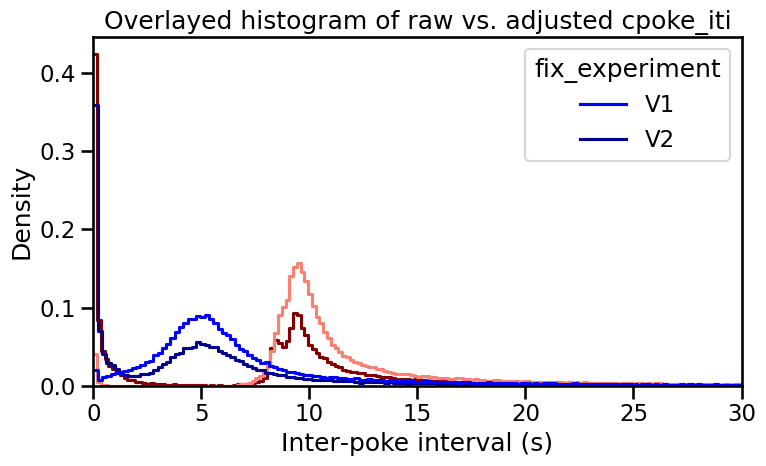

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

# Raw cpoke_iti
sns.histplot(
    data=merged,
    x="cpoke_iti",
    element="step",
    stat="density",
    # label="Raw cpoke_iti",
    fill=False,
    hue="fix_experiment",
    palette=["salmon", "maroon"]
)
plt.legend(loc="upper left")

# Adjusted cpoke_iti
sns.histplot(
    data=merged,
    x="cpoke_iti_adjusted",
    element="step",
    stat="density",
    label="Adjusted cpoke_iti",
    fill=False,
    hue="fix_experiment",
    palette=["blue", "darkblue"]

)

plt.xlabel("Inter‐poke interval (s)")
plt.ylabel("Density")
plt.title("Overlayed histogram of raw vs. adjusted cpoke_iti")
plt.xlim(0, 30)
# plt.legend()
plt.tight_layout()
plt.show()

In [77]:
pdf

,sessid,animal_id,trial,cpoke_dur,cpoke_iti,post_settling_violation,settling_violation,was_rewarded,fixation_dur,date,stage,fix_experiment,relative_cpoke_dur,was_valid,cpoke_tit_timeout_adj,prev_was_valid
0,965069,R040,2,0.0304,72.409421,0,0,1,0.011000,01-Aug-2024 14:28:29,5.0,V1,0.019400,True,72.409421,None
1,965069,R040,3,0.0242,28.839480,0,0,1,0.012000,01-Aug-2024 14:28:29,5.0,V1,0.012200,True,28.839480,True
2,965069,R040,4,0.0259,12.954300,0,0,1,0.013000,01-Aug-2024 14:28:29,5.0,V1,0.012900,True,12.954300,True
3,965069,R040,5,0.0241,15.057600,0,0,1,0.014000,01-Aug-2024 14:28:29,5.0,V1,0.010100,True,15.057600,True
4,965069,R040,6,0.0444,13.752699,0,0,1,0.015000,01-Aug-2024 14:28:29,5.0,V1,0.029400,True,13.752699,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179946,966978,R057,337,1.9366,10.168700,0,0,1,1.528493,21-Aug-2024 16:49:12,10.0,V2,0.408107,True,10.168700,True
179947,966978,R057,338,1.7166,0.097300,0,0,1,1.556001,21-Aug-2024 16:49:12,10.0,V2,0.160599,True,0.097300,True
179948,966978,R057,339,1.8355,15.058700,0,0,1,1.711663,21-Aug-2024 16:49:12,10.0,V2,0.123837,True,15.058700,True
179949,966978,R057,340,1.5432,27.879500,0,0,1,1.449541,21-Aug-2024 16:49:12,10.0,V2,0.093659,True,27.879500,True


In [78]:
merge

,sessid,animal_id,trial,cpoke_dur,cpoke_iti,post_settling_violation,settling_violation,was_rewarded,fixation_dur,date,stage,fix_experiment,relative_cpoke_dur,was_valid,cpoke_tit_timeout_adj,prev_was_valid,is_first_cpoke,prev_sma_iti,prev_timeout,cpoke_iti_adjusted
0,965069,R040,2,0.0304,72.409421,0,0,1,0.011000,01-Aug-2024 14:28:29,5.0,V1,0.019400,True,72.409421,None,True,12.332821,0.0,60.076600
1,965069,R040,3,0.0242,28.839480,0,0,1,0.012000,01-Aug-2024 14:28:29,5.0,V1,0.012200,True,28.839480,True,True,5.777362,0.0,23.062118
2,965069,R040,4,0.0259,12.954300,0,0,1,0.013000,01-Aug-2024 14:28:29,5.0,V1,0.012900,True,12.954300,True,True,4.993989,0.0,7.960311
3,965069,R040,5,0.0241,15.057600,0,0,1,0.014000,01-Aug-2024 14:28:29,5.0,V1,0.010100,True,15.057600,True,True,4.821803,0.0,10.235797
4,965069,R040,6,0.0444,13.752699,0,0,1,0.015000,01-Aug-2024 14:28:29,5.0,V1,0.029400,True,13.752699,True,True,5.129691,0.0,8.623008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179946,966978,R057,337,1.9366,10.168700,0,0,1,1.528493,21-Aug-2024 16:49:12,10.0,V2,0.408107,True,10.168700,True,True,2.631407,0.0,7.537293
179947,966978,R057,338,1.7166,0.097300,0,0,1,1.556001,21-Aug-2024 16:49:12,10.0,V2,0.160599,True,0.097300,True,True,NaN,NaN,NaN
179948,966978,R057,339,1.8355,15.058700,0,0,1,1.711663,21-Aug-2024 16:49:12,10.0,V2,0.123837,True,15.058700,True,True,3.021916,0.0,12.036784
179949,966978,R057,340,1.5432,27.879500,0,0,1,1.449541,21-Aug-2024 16:49:12,10.0,V2,0.093659,True,27.879500,True,True,4.632623,0.0,23.246877


,median,mean,std,size
fix_experiment,,,,
V1,3.877285,16.747768,57.499377,17747
V2,0.149100,4.842950,52.438278,22523


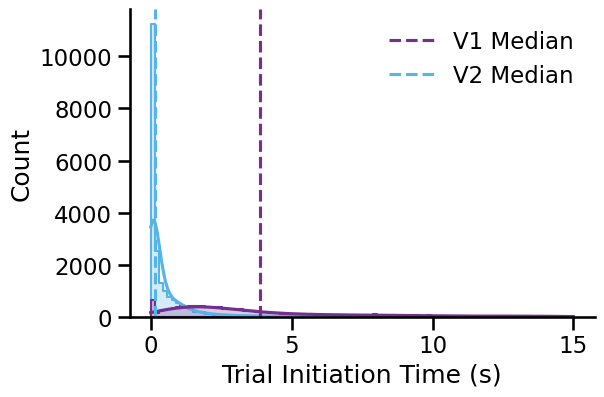

In [100]:
sns.set_context("talk")
MAX_ITI = 15
plot_df = merged.query("stage in @c.GROWING_STAGES and prev_was_valid==False")

fig, ax = plt.subplots(figsize=(6,4))
sns.despine()
sns.histplot(
    data=plot_df.query("cpoke_iti_adjusted < @MAX_ITI"),
    x="cpoke_iti_adjusted",
    ax=ax,
    hue="fix_experiment",
    hue_order=c.HUE_ORDER_EXP,
    kde=True,
    element="step",
    palette =c.EXP_PALETTE,
)

ax.set(
    xlabel="Trial Initiation Time (s)",
)



# Calculate statistics for each fix_experiment
stats = plot_df.groupby('fix_experiment')['cpoke_iti_adjusted'].agg(['median', 'mean', 'std', 'size'])

# Print the statistics
(stats.reset_index())

# Plot median lines for each fix_experiment
for i, (exp, median) in enumerate(stats['median'].items()):
    ax.axvline(median, color=c.EXP_PALETTE[i], linestyle='--', label=f'{exp} Median')


# Add legend to the plot without a frame
ax.legend(title="", frameon=False)
ax.get_legend().set_title("")
# fig.savefig("figures/V0_fig4e_v2_violation_tit_growth.png", dpi=300, bbox_inches="tight")

stats

In [94]:
plot_df.animal_id.nunique()

17

In [95]:
plot_df.groupby('animal_id').date.nunique()

animal_id
R040    9
R041    9
R042    9
R043    9
R045    9
R046    9
R047    9
R048    9
R049    9
R050    9
R051    8
R052    9
R053    9
R054    9
R055    9
R056    9
R057    9
Name: date, dtype: int64

In [96]:
len(plot_df)

5309

In [ ]:
plot_df.cpoke_iti.describe()

count    5309.000000
mean       24.808905
std        58.461386
min         0.002500
25%         8.104101
50%         9.898400
75%        18.785200
max      1344.125099
Name: cpoke_iti, dtype: float64

In [106]:
merged.columns


Index(['sessid', 'animal_id', 'trial', 'cpoke_dur', 'cpoke_iti',
       'post_settling_violation', 'settling_violation', 'was_rewarded',
       'fixation_dur', 'date', 'stage', 'fix_experiment', 'relative_cpoke_dur',
       'was_valid', 'cpoke_tit_timeout_adj', 'prev_was_valid',
       'is_first_cpoke', 'prev_sma_iti', 'prev_timeout', 'cpoke_iti_adjusted'],
      dtype='object')

In [112]:
merged.query("stage in @c.PROBE_STAGES and prev_was_valid==False").post_settling_violation.value_counts()

post_settling_violation
0    3998
1    1311
Name: count, dtype: int64

,median,mean,std,size
fix_experiment,,,,
V1,5.377098,20.999058,56.800883,2629
V2,4.051878,20.578715,63.815518,2680


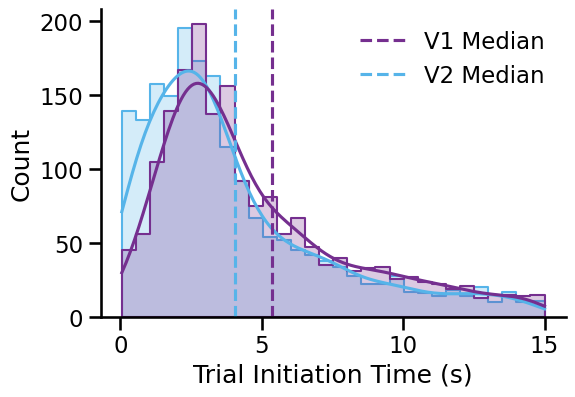

In [ ]:
sns.set_context("talk")
MAX_TIT = 15
plot_df = merged.query("stage in @c.PROBE_STAGES and prev_was_valid==False and ")

fig, ax = plt.subplots(figsize=(6,4))
sns.despine()
sns.histplot(
    data=plot_df.query("cpoke_iti_adjusted < @MAX_TIT"),
    x="cpoke_iti_adjusted",
    ax=ax,
    hue="fix_experiment",
    hue_order=c.HUE_ORDER_EXP,
    kde=True,
    element="step",
    palette =c.EXP_PALETTE,
)

ax.set(
    xlabel="Trial Initiation Time (s)",
)



# Calculate statistics for each fix_experiment
stats = plot_df.groupby('fix_experiment')['cpoke_iti_adjusted'].agg(['median', 'mean', 'std', 'size'])

# Print the statistics
(stats.reset_index())

# Plot median lines for each fix_experiment
for i, (exp, median) in enumerate(stats['median'].items()):
    ax.axvline(median, color=c.EXP_PALETTE[i], linestyle='--', label=f'{exp} Median')


# Add legend to the plot without a frame
ax.legend(title="", frameon=False)
ax.get_legend().set_title("")
# fig.savefig("figures/V0_fig4e_v2_violation_tit_growth.png", dpi=300, bbox_inches="tight")

stats